In [78]:
import numpy as np 
import plotly.graph_objects as go
from matplotlib import pyplot as plt
import jax 
import jax.numpy as jnp
from jax import jit, vmap
import optax
from tqdm import tqdm

In [176]:
import importlib
import sys
from pathlib import Path
import os 
sys.path.append(str(Path(os.getcwd()).parent / "src"))

import constriction 
importlib.reload(constriction) 
from constriction import total_energy2, total_energy, F, h 

In [211]:
E1 = vmap(jit(total_energy), in_axes=(0, None, None))
E2_partial = vmap(jit(total_energy2), in_axes=(None, 0, None, None))
E2 = vmap(E2_partial, in_axes=(0, None, None, None))



E2_diagonal = vmap(jit(total_energy2), in_axes=(0, 0, None, None))

theta1s = np.linspace(1e-5, np.pi/2*0.99, 100)
h2_R_ratio = np.sin(theta1s)
k = 0.5
nu = 0.2 # when nu = 0.5, the interface has the same energy as the poles 
E = E2(theta1s, h2_R_ratio, k, nu) 

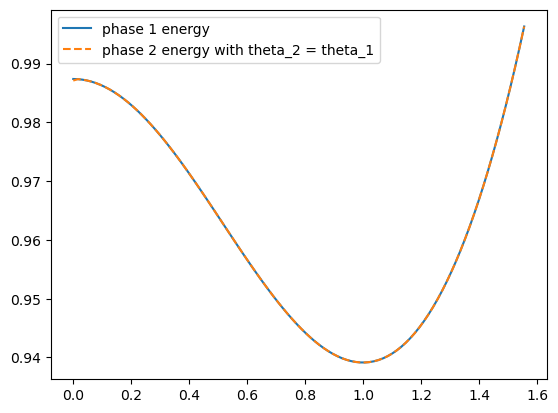

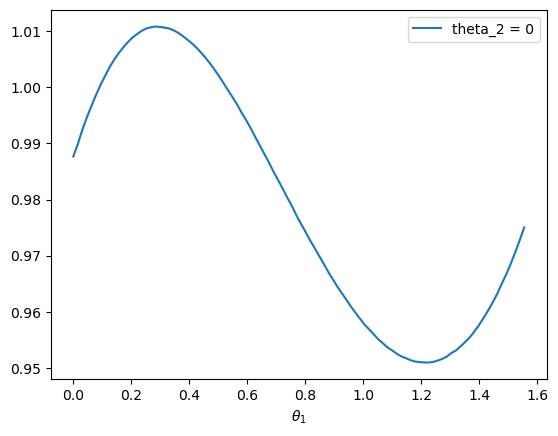

In [199]:
plt.plot(theta1s, E1(theta1s, np.pi/2, k), label='phase 1 energy')
plt.plot(theta1s, E2_diagonal(theta1s, h2_R_ratio, k, nu), '--', label='phase 2 energy with theta_2 = theta_1')
plt.legend() 
plt.show() 

h2_constant = 1e-4
plt.plot(theta1s, E2_diagonal(theta1s, h2_constant*F(theta1s), k, nu), label='theta_2 = 0')
plt.xlabel(r'$\theta_1$')
plt.legend()
plt.show() 
# this is not exactly 60 degrees because we made approximation 

/var/folders/5n/0rvnm9350db7gk5vdnj3tn6h0000gn/T/ipykernel_15787/1458863085.py:18: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar(label='Energy')


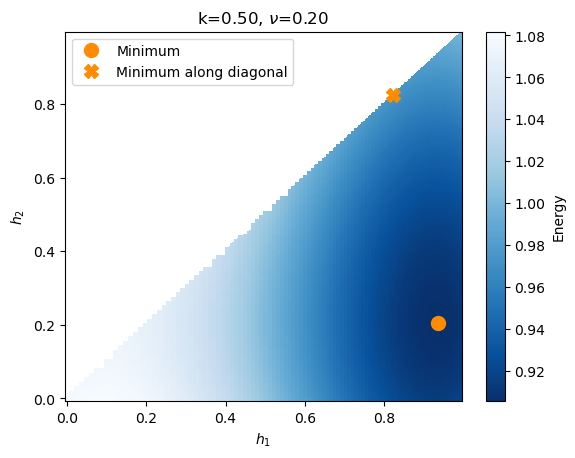

In [212]:
theta1s_grid, theta2s_grid = np.meshgrid(theta1s, h2_R_ratio)

h1 = h(theta1s_grid) 
h2 = theta2s_grid/F(theta1s_grid) 
mask = (h2 > h1) 

# Apply the mask to the energy matrix
masked_array = np.ma.masked_array(E.T, mask=mask)
min_index = masked_array.argmin(fill_value=np.inf)
min_index = np.unravel_index(min_index, masked_array.shape)

# # Find minimum energy along the diagonal 
min_index_diag = np.argmin(E2_diagonal(theta1s, h2_R_ratio, k, nu))
h1_diag = h(theta1s) 
h2_diag = h2_R_ratio/F(theta1s)

plt.pcolor(h1, h2, masked_array, cmap='Blues_r')
plt.colorbar(label='Energy')
plt.plot(h1[min_index], h2[min_index], 'o', color='darkorange', markersize=10, label='Minimum')
plt.plot(h1_diag[min_index_diag], h2_diag[min_index_diag], 'X', color='darkorange', markersize=10, label='Minimum along diagonal')
plt.xlabel(r'$h_1$')
plt.ylabel(r'$h_2$')
plt.title(r'k={:.2f}, $\nu$={:.2f}'.format(k, nu)) 
plt.legend()
plt.show() 

In [170]:
def energy(params, k, nu): 
    theta1, delta = params 
    h2_R_ratio = jnp.sin(theta1 - delta)
    E2_val = total_energy2(theta1, h2_R_ratio, k, nu) 
    return E2_val 

# Setup optimizer
optimizer = optax.adam(learning_rate=0.005)

def find_minimum(k, nu, steps=1000):
    # Initial parameters
    params = jnp.array([np.pi/2*0.9, 0.1])
    opt_state = optimizer.init(params)
    loss_fn = lambda params: energy(params, k, nu)
    
    # One step of optimization
    @jit
    def step(params, opt_state): 
        loss_value, grads = jax.value_and_grad(loss_fn)(params)
        updates, new_opt_state = optimizer.update(grads, opt_state)
        new_params = optax.apply_updates(params, updates)
        
        new_params = new_params.at[0].set(jnp.clip(new_params[0], 0, jnp.pi/2))
        new_params = new_params.at[1].set(jnp.clip(new_params[1], 0, new_params[0]))
        
        return new_params, new_opt_state, loss_value

    # Optimization loop
    for _ in range(steps):
        params, opt_state, loss_value = step(params, opt_state)
    
    return params, loss_value

# Run optimization
# Run optimization
optimal_params = [] 
min_energies = [] 
ks = jnp.arange(0.1, 2, 0.1)
nus = jnp.arange(0.1, 1, 0.1)
for k in tqdm(ks):
    for nu in nus:
        p, e = find_minimum(k, nu)
        optimal_params.append(p)
        min_energies.append(e)

100%|██████████| 19/19 [00:23<00:00,  1.22s/it]


In [174]:
optimal_params = np.array(optimal_params)
print(optimal_params.shape)
min_energies = np.array(min_energies).reshape((len(ks), len(nus)))
theta2 = (optimal_params[:, 0] - optimal_params[:, 1]).reshape((len(ks), len(nus)))
theta1 = optimal_params[:, 0].reshape((len(ks), len(nus)))

h2 = np.sin(theta2)/F(theta1)
h1 = np.sin(theta1)/F(theta1) 

(171, 2)


In [ ]:
np.save('sim_data/theta1.npy', theta1)
np.save('sim_data/theta2.npy', theta2)
np.save('sim_data/min_energy.npy', min_energies)


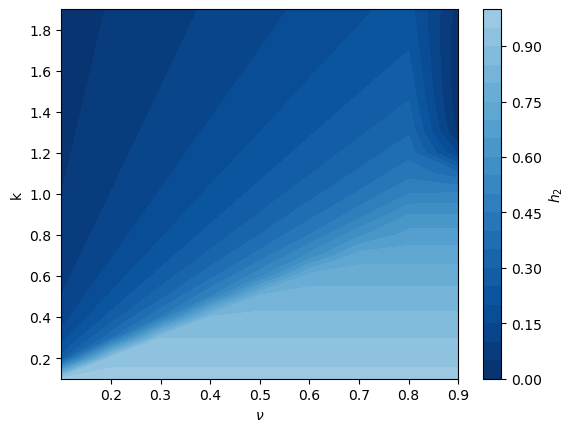

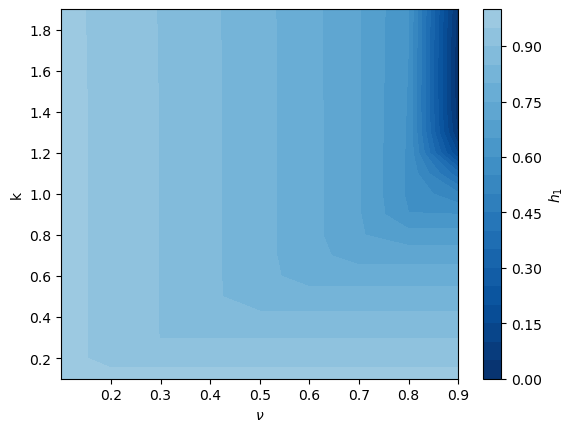

In [175]:
plt.contourf(nus, ks, h2, cmap='Blues_r', vmin=0, vmax=np.pi/2, levels=20)
plt.colorbar(label=r'$h_2$')
plt.xlabel(r'$\nu$')
plt.ylabel(r'k')
plt.show()


plt.contourf(nus, ks, h1, cmap='Blues_r', vmin=0, vmax=np.pi/2, levels=20)
plt.colorbar(label=r'$h_1$')
plt.xlabel(r'$\nu$')
plt.ylabel(r'k')
plt.show()

## Explore the energy when $\theta_1$ is chosen to be the minimum of the phase 1 energy

In [ ]:
thetas = np.linspace(0, np.pi/2*0.99, 100)

k_vals = [0.1, 0.4, 1]
nu_vals = [0.1, 0.5, 1] 

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
alphas = [0.5, 0.8, 1]


for (i, k) in enumerate(k_vals): 
    for (j, nu) in enumerate(nu_vals):
        E_vals, phase_2, E1_vals = combined_energy(thetas, k, nu)
        if phase_2: 
            plt.plot(thetas, E1_vals, linestyle='--', color=colors[i]) 
        plt.plot(thetas, E_vals, label=fr'k={k}, $\nu$={nu}', color=colors[i], alpha=alphas[j])
        plt.plot(thetas[np.argmin(E_vals)], E_vals[np.argmin(E_vals)], 'o', color=colors[i])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$E(\theta)$')
plt.savefig('../figures/phase_2_energy.png', bbox_inches='tight')
plt.show() 

NameError: name 'combined_energy' is not defined

In [8]:
N = 50
k_vals = np.linspace(0, 2, N)
nu_vals = np.linspace(0, 1, N)
minimum_theta = np.empty((N, N))
phase_2_arr = np.empty((N, N), dtype=bool)

for i, k in enumerate(k_vals):
    for j, nu in enumerate(nu_vals):
        E_vals, phase_2, E1_vals = combined_energy(thetas, k, nu)
        minimum_theta[i, j] = thetas[np.argmin(E_vals)]
        phase_2_arr[i, j] = (np.argmin(E_vals) == np.argmin(E1_vals))


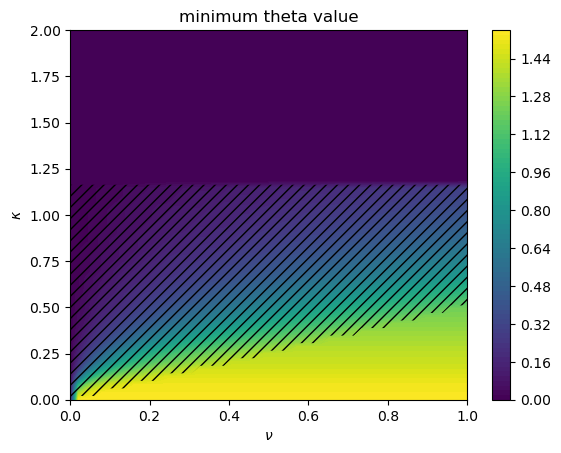

In [9]:

plt.contourf(nu_vals, k_vals, minimum_theta, levels=100)
plt.colorbar()
plt.contourf(nu_vals, k_vals, phase_2_arr, levels=[0, 0.5], colors=['none'], hatches=['///']) 
plt.ylabel(r"$\kappa$")
plt.xlabel(r'$\nu$')
plt.title('minimum theta value')
plt.savefig('../figures/phase2_phase_diagram.png')
plt.show() 